## Figure 6

![title](../assets/Fig6.png)

In [8]:
%load_ext autoreload
%autoreload 2
import sys
import logging
import itertools
from tqdm import tqdm
from pathlib import Path

sys.path.insert(0, "./prepare_data/")

import yaml
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import Figure4_neurons as neurons
import Figure6_prepare_data as prepare_data
import connectome_utils
# import Figure4_graph_tools as graph_tools
# import Figure4_generate_grooming_nets_monosynaptic as gen_network
from common import *

# import plot_utils

DATA_PATH = Path(
    "../data"
)
EXPORT_PATH = Path(
    "../results/Figure6"
)
EXPORT_PATH.mkdir(exist_ok=True, parents=True)


FIGSIZE = {'width': 1.2, 'length': 0.9}

# disable matplotlib logger
logging.getLogger("matplotlib.font_manager").disabled = True

plt.style.use('./config.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Panel A: Unilateral selectivity index of antennal motor neuron 4 for selected models. 

Note that we omit the processing here due to the large dataset size.

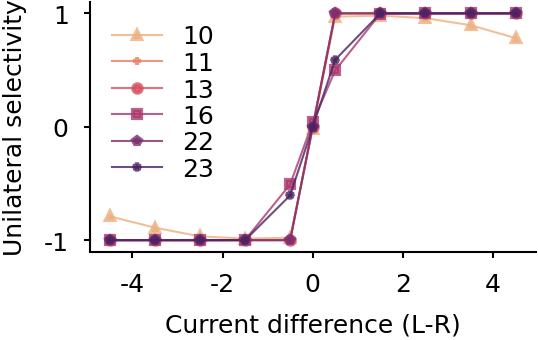

In [9]:
current_pairs = [
    (0.5, 5.0),
    (1.0, 4.5),
    (1.5, 4.0),
    (2.0, 3.5),
    (2.5, 3.0),
    (3.0, 3.0),
    (3.0, 2.5),
    (3.5, 2.0),
    (4.0, 1.5),
    (4.5, 1.0),
    (5.0, 0.5),
]

diagonal_ratio = load_data(DATA_PATH / "Fig6_panelA.pkl")

seed2model = {9: 10, 10: 11, 12: 13, 15: 16, 22: 22, 23: 23}
markers_seeds = {
    seed: marker
    for seed, marker in zip(
        seed2model, itertools.cycle(["^", "+", "o", "s", "p", "*", "d", "X"])
    )
}
cmap = mpl.colormaps["flare"]

# Take colors at regular intervals spanning the colormap.
colors = list(cmap(np.linspace(0, 1, len(seed2model))))
colors_seed = {seed: color for seed, color in zip(seed2model.keys(), colors)}

with plt.style.context("./config.mplstyle"):
    fig, ax = plt.subplots(
        1, 1, figsize=(FIGSIZE["width"] * 1.6, FIGSIZE["length"] * 1.2), dpi=300
    )
    for k, (seed, model) in enumerate(seed2model.items()):
        ax.plot(
            [x[0] - x[1] for x in current_pairs],
            diagonal_ratio[seed],
            marker=markers_seeds[seed],
            color=colors_seed[seed],
            alpha=0.8,
            label=model,
            markersize=2,
            lw=0.5,
        )

    ax.set_ylabel("Unilateral selectivity")
    ax.set_xlabel("Current difference (L-R)")
    ax.legend(ncols=1, labelspacing=0.1, columnspacing=0.4, fontsize=6)

    ax.set_yticks([0, 0.5, 1], labels=[-1, 0, 1])
    ax.set_xticks([-4, -2, 0, 2, 4], labels=[-4, -2, 0, 2, 4])

    fig.savefig(
        EXPORT_PATH / "Fig6_panelA_sigmoid.png", bbox_inches="tight", dpi=300
    )
    plt.show()

## Panel B: antennal MN4 responses to different input current pairs.

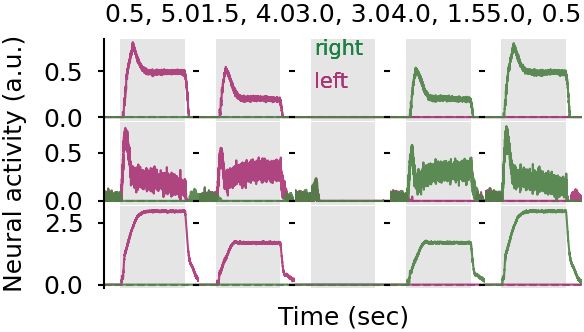

In [10]:
mn4_response = load_data(DATA_PATH / "Fig6_panelB.pkl")
seed_numbers = [10, 15, 22]
RELU = True

with plt.style.context("./config.mplstyle"):

    current_pairs = [
        (0.5, 5.0),
        (1.5, 4.0),
        (3.0, 3.0),
        (4.0, 1.5),
        (5.0, 0.5),
    ]

    diagonal_ratio = {seed: [] for seed in seed_numbers}
    fig, axs = plt.subplots(
        len(seed_numbers),
        5,
        figsize=(FIGSIZE["width"] * 1.6, FIGSIZE["length"] * 1.2),
        dpi=300,
        sharex="col",
        sharey="row",
    )

    for k, seed in enumerate(seed_numbers):

        count = 0
        for left_current_val, right_current_val in current_pairs:
            voltage_left_mn4, voltage_right_mn4 = mn4_response[seed][
                (left_current_val, right_current_val)
            ]

            if RELU:
                voltage_left_mn4 = relu_function(voltage_left_mn4)
                voltage_right_mn4 = relu_function(voltage_right_mn4)

            axs[k, count].axhline(0, color="grey", linewidth=0.5, linestyle="--")

            axs[k, count].plot(
                voltage_left_mn4,
                color="#AA3375",
                linewidth=0.5,
                alpha=0.9,
                label="left",
            )
            axs[k, count].plot(
                voltage_right_mn4,
                color="#4D8044",
                linewidth=0.5,
                alpha=0.9,
                label="right",
            )

            # span between stim interval
            axs[k, count].axvspan(2500, 4500, color="grey", alpha=0.2, linewidth=0)
            axs[0, count].set_title(
                f"{left_current_val}, {right_current_val}", fontsize=6, y=0.9
            )
            axs[k, count].set_xlim(2000, 5000)
            axs[k, count].set_xticks([2000, 3000, 4000, 5000], labels=[2, 3, 4, 5])
            if count > 0:
                axs[k, count].spines["left"].set_visible(False)
            if k < 3:
                axs[k, count].spines["bottom"].set_visible(False)
                # no x ticks
                axs[k, count].set_xticks([])
            count += 1

        axs[-1, 2].set_xlabel("Time (sec)")
        axs[1, 0].set_ylabel("Neural activity (a.u.)")
        axs[0, 2].text(
            0.2,
            0.8,
            "right",
            transform=axs[0, 2].transAxes,
            fontsize=5,
            color="#1D8044",
        )
        axs[0, 2].text(
            0.2, 0.4, "left", transform=axs[0, 2].transAxes, fontsize=5, color="#AA3375"
        )
    plt.tight_layout(pad=-0.05)
    fig.subplots_adjust(hspace=0.02)
    fig.savefig(
        EXPORT_PATH / f"Fig6_panelB_MN4_{RELU}.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()

## Panel C: heatmaps

In [11]:
normalize_min_max = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

def plot_contour(
    currents,
    area_under_right,
    area_under_left,
    dot_dictionary={},
    title="",
    export_path=None,
    cmap="RdBu_r",
):

    area_under_right_norm = normalize_min_max(area_under_right)
    area_under_left_norm = normalize_min_max(area_under_left)
    area_difference = area_under_left_norm - area_under_right_norm

    fig, ax = plt.subplots(
        figsize=(FIGSIZE["width"] * 1.25, FIGSIZE["length"] * 1.45),
        constrained_layout=True,
    )

    # Setup for first plot
    pcm1 = ax.contourf(
        currents, currents, area_difference, levels=20, cmap=cmap, vmin=-1, vmax=1
    )
    pcm1_c = ax.contour(
        currents,
        currents,
        area_difference,
        levels=20,
        colors=["black"],
        vmin=-1,
        vmax=1,
        alpha=0.5,
    )
    ax.set_xticks(np.arange(currents[0], currents[-1], 1.0))
    ax.set_yticks(np.arange(currents[0], currents[-1], 1.0))
    cbar = fig.colorbar(pcm1, ax=ax, shrink=0.6, pad=0.02, orientation="vertical")
    # Label
    cbar.set_label("aMN activity (a.u.)", rotation=270, labelpad=0.15, fontsize=5)
    # cbar ticks
    cbar.set_ticks([-1, 0, 1])

    for dot_location, dot_color in dot_dictionary.items():
        ax.scatter(*dot_location, marker=".", color=dot_color, s=10)

    ax.set_ylabel("R input (a.u.)")
    ax.set_xlabel("L input (a.u.)")
    ax.set_title(title)

    if export_path is not None:
        plt.savefig(export_path, dpi=300)

    plt.show()

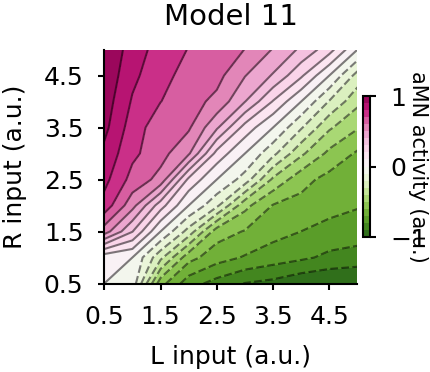

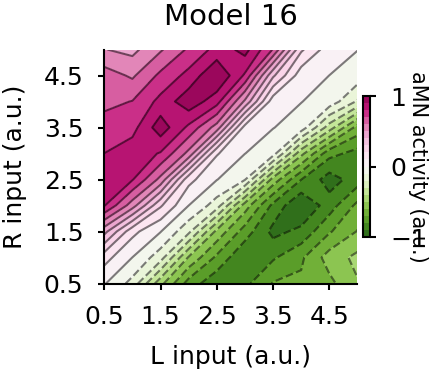

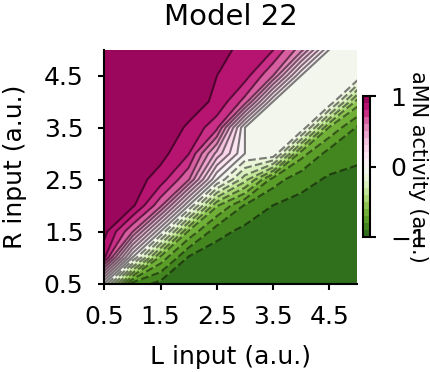

In [12]:
seed_numbers = [10, 15, 22]
current_levels = np.arange(0.5, 5.5, 0.5)

# Due to storage constraints, we skip the processing part and directly take
# the data from the pre-processed data from a pickle file.
heatmap_data = load_data(DATA_PATH / "Fig6_panelC.pkl")


for seed in seed_numbers:
    # data_path_intact = (
    #     lab_server_path
    #     / f"connectome_sym_adj_MLP_decoder_reLu_seed_{seed}/silence_intact"
    # )

    for motor_neuron in ["ANTEN_MN4"]:
        # This function is accessible under prepare_data/Figure6_prepare_data.py
        # area_under_right, area_under_left = calc_area_under_neuron(
        #     current_list=current_levels,
        #     stim_interval=(2500, 4500),
        #     data_path=data_path_intact,
        #     neurons_ordered=neuron_index,
        #     neuron_name=motor_neuron,
        # )

        area_under_left = heatmap_data[seed]["left"]
        area_under_right = heatmap_data[seed]["right"]

        plot_contour(
            current_levels,
            area_under_right,
            area_under_left,
            title=f"Model {seed2model[seed]}",
            cmap="PiYG_r",
            export_path=EXPORT_PATH
            / f"Fig6_panelB_{motor_neuron}_seed{seed}.pdf",
        )

## Panel E: activation and silencing screen. 

In [13]:
# Just to order
neurons_to_show = [
    'intact',
    'ABN1',
    'ABN2',
    'ABN3',
    'ADN1',
    'ADN3',
    'DN18',
    'DN22',
    'DN52',
    'DN55',
    'WED',
    'IN48',
    'cluster_4',
    'cluster_5',
    'cluster_6',
    'cluster_7',
    'cluster_8',
    'cluster_9',
    'cluster_10',
    'cluster_11',
    'cluster_12',
    'cluster_13',
    'cluster_14',
    'cluster_15',
    'cluster_16',
    'cluster_17',
    'cluster_18',
    'cluster_19',
    'cluster_20',
    'cluster_21',
    'cluster_22',
    'cluster_24',
    'cluster_25',
    'cluster_27',
    'cluster_28',
    'cluster_30',
    'cluster_33',
    'cluster_34',
    'cluster_35',
    'cluster_36',
    'cluster_37',
    'cluster_38',
    'cluster_41',
    'cluster_43',
    'cluster_44',
    'cluster_45',
    'cluster_46',
    'cluster_47',
    'cluster_48',
    'cluster_49',
    'cluster_50',
    'cluster_51',
    'cluster_52',
    'cluster_54',
    'cluster_55',
    'cluster_56',
    'cluster_57',
    'cluster_58',
    'cluster_59',
    'cluster_60',
    'cluster_61',
    'cluster_62',
    'cluster_63',
    'cluster_64',
    '12A_DN5',
    '12A_DN33',
    # Premotor neurons
    'cluster_23',
    'cluster_26',
    'cluster_29',
    'cluster_39',
    'cluster_40',
    'cluster_42',
    'cluster_53',
]

labels = [name.replace("cluster_", "c") for name in neurons_to_show]

# Load the prerequisities
cluster2neuron = pd.read_pickle(DATA_PATH / "cluster2neuron.pkl")
neurons_ordered = list(np.load(DATA_PATH / "neuron_names_ordered.npy"))
cluster2nt = pd.read_pickle(DATA_PATH / "cluster2nt.pkl")
node2name = pd.read_pickle(DATA_PATH / "node2name.pkl")

Note that we omit the processing here due to the large dataset size. The code for the processing is available under ```prepare_data/Figure6_prepare_data.py```. Specifically, see the functions: 
* ```identify_important_neurons_activate```: to obtain df_activate
* ```identify_important_neurons_silencing```: to obtain df_silence
* ```count_number_of_neurons_active```: to obtain df_global_act


/var/folders/tq/lmjf3_8j2pgc58qrzj3pl2x00000gp/T/ipykernel_29473/3573381253.py:18: UserWarning: 
The palette list has fewer values (1) than needed (73) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(
/var/folders/tq/lmjf3_8j2pgc58qrzj3pl2x00000gp/T/ipykernel_29473/3573381253.py:26: UserWarning: 
The palette list has fewer values (1) than needed (73) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(
/var/folders/tq/lmjf3_8j2pgc58qrzj3pl2x00000gp/T/ipykernel_29473/3573381253.py:34: UserWarning: 
The palette list has fewer values (1) than needed (73) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(


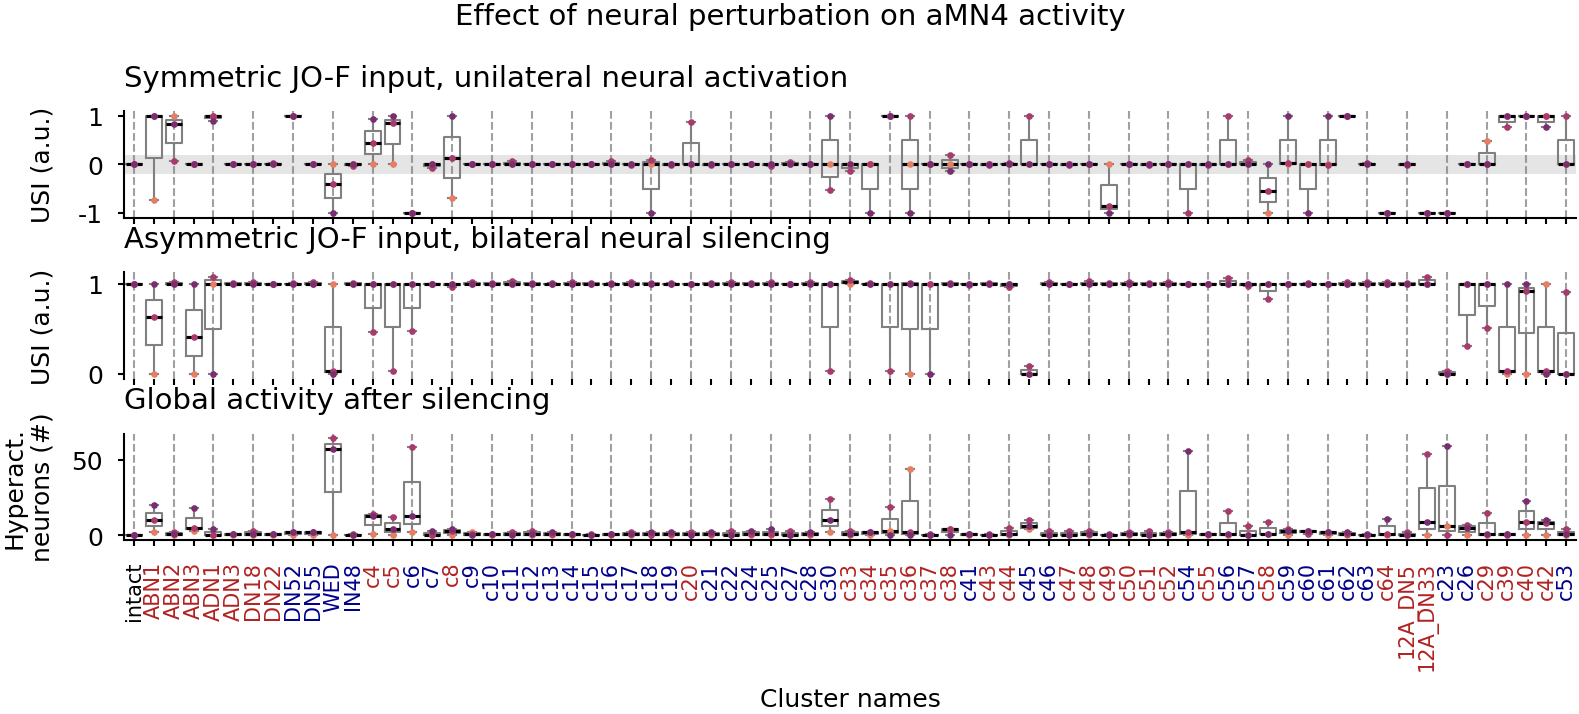

In [14]:
df_activate = load_data(DATA_PATH / "Fig6_panelE-F_activate.pkl")
df_silence = load_data(DATA_PATH / "Fig6_panelE-F_silence.pkl")
df_global_act = load_data(DATA_PATH / "Fig6_panelE-F_global_act.pkl")

with plt.style.context("./config.mplstyle"):

    fig, axs = plt.subplots(3, 1, figsize=(5.25, 2.25), sharex=True)

    # Put vertical line every other neuron
    for i in range(0, len(neurons_to_show), 2):
        axs[0].axvline(i, color="grey", linestyle="--", linewidth=0.5, alpha=0.75)
        axs[1].axvline(i, color="grey", linestyle="--", linewidth=0.5, alpha=0.75)
        axs[2].axvline(i, color="grey", linestyle="--", linewidth=0.5, alpha=0.75)

    # Span between the two intervals in y
    axs[0].axhspan(0.4, 0.6, color="grey", alpha=0.2, linewidth=0)

    sns.boxplot(
        data=df_activate.iloc[:, 1:],
        ax=axs[0],
        palette=["grey"],
        medianprops={"linewidth": 0.75, "color": "black"},
        fill=False,
        showfliers=False,
    )
    sns.boxplot(
        data=df_silence.iloc[:, 1:],
        ax=axs[1],
        palette=["grey"],
        medianprops={"linewidth": 0.75, "color": "black"},
        fill=False,
        showfliers=False,
    )
    sns.boxplot(
        data=df_global_act.iloc[:, 1:],
        ax=axs[2],
        palette=["grey"],
        medianprops={"linewidth": 0.75, "color": "black"},
        fill=False,
        showfliers=False,
    )

    for seed in [10, 15, 22]:
        color = colors_seed[seed]
        alpha = 1

        sns.stripplot(
            data=df_activate[df_activate.seed == seed].iloc[:, 1:],
            color=color,
            ax=axs[0],
            alpha=alpha,
            size=1.6,
        )
        sns.stripplot(
            data=df_silence[df_silence.seed == seed].iloc[:, 1:],
            color=color,
            ax=axs[1],
            alpha=alpha,
            size=1.6,
        )
        sns.stripplot(
            data=df_global_act[df_global_act.seed == seed].iloc[:, 1:],
            color=color,
            ax=axs[2],
            alpha=alpha,
            size=1.6,
        )

    axs[0].set_xticks(range(len(df_silence.columns[1:])), labels=[])
    axs[1].set_xticks(range(len(df_silence.columns[1:])), labels=[])
    axs[2].set_xticks(
        range(len(df_silence.columns[1:])),
        labels=[name.replace("cluster_", "c") for name in df_silence.columns[1:]],
        rotation=90,
        ha="center",
        fontsize=5,
    )
    axs[0].set_yticks([0, 0.5, 1], labels=[-1, 0, 1])
    axs[1].set_yticks([0.5, 1], labels=[0, 1])

    axs[0].spines["bottom"].set_visible(True)
    axs[1].spines["bottom"].set_visible(False)
    axs[2].spines["bottom"].set_visible(True)

    for tick, label in zip(axs[-1].get_xticks(), axs[-1].get_xticklabels()):

        if label.get_text() == "intact":
            label.set_color("black")
        else:
            label.set_color(
                "firebrick"
                if cluster2nt[label.get_text().replace("c", "cluster_")] == "excitatory"
                else "darkblue"
            )

    axs[0].set_ylabel("USI (a.u.)")
    axs[1].set_ylabel("USI (a.u.)")
    axs[2].set_ylabel("Hyperact.\nneurons (#)")
    axs[2].set_xlabel("Cluster names")

    axs[0].set_title("Symmetric JO-F input, unilateral neural activation", loc="left")
    axs[1].set_title("Asymmetric JO-F input, bilateral neural silencing", loc="left")
    axs[2].set_title("Global activity after silencing", loc="left")
    # align labels
    fig.align_ylabels(axs)

    plt.suptitle("Effect of neural perturbation on aMN4 activity", y=1.05)
    plt.tight_layout(pad=0)

    fig.savefig(
        EXPORT_PATH / f"Fig6_panelE-F.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()

In [15]:
contra_neuron_activate = []
columns = df_activate.columns[1:]
print("Neurons important for contralateral aMN4 activity")
for column in columns:
    if df_activate[column].median() > 0.6:
        print("Seeds 10, 15, 22: ", column)
        contra_neuron_activate.append(column.replace('cluster_', 'c_') + "_L")


print("-"*30)
print("Neurons important for ipsilateral aMN4 activity")
ipsi_neuron_activate = []
for column in columns:
    if df_activate[column].median() < 0.4:
        print("Seeds 10, 15, 22: ", column)
        ipsi_neuron_activate.append(column.replace('cluster_', 'c_') + "_R")


print("-"*30)
print("Neurons affecting aMN4 activity after silencing")
silencing_importants = []
for column in columns:
    if df_silence[column].median() < 0.9:
        print("Seeds 10, 15, 22: ", column)
        silencing_importants.append(column.replace('cluster_', 'c_') + "_L")

Neurons important for contralateral aMN4 activity
Seeds 10, 15, 22:  ABN1
Seeds 10, 15, 22:  ABN2
Seeds 10, 15, 22:  ADN1
Seeds 10, 15, 22:  DN52
Seeds 10, 15, 22:  cluster_4
Seeds 10, 15, 22:  cluster_5
Seeds 10, 15, 22:  cluster_35
Seeds 10, 15, 22:  cluster_62
Seeds 10, 15, 22:  cluster_39
Seeds 10, 15, 22:  cluster_40
Seeds 10, 15, 22:  cluster_42
------------------------------
Neurons important for ipsilateral aMN4 activity
Seeds 10, 15, 22:  WED
Seeds 10, 15, 22:  cluster_6
Seeds 10, 15, 22:  cluster_49
Seeds 10, 15, 22:  cluster_58
Seeds 10, 15, 22:  cluster_64
Seeds 10, 15, 22:  12A_DN33
Seeds 10, 15, 22:  cluster_23
------------------------------
Neurons affecting aMN4 activity after silencing
Seeds 10, 15, 22:  ABN1
Seeds 10, 15, 22:  ABN3
Seeds 10, 15, 22:  WED
Seeds 10, 15, 22:  cluster_45
Seeds 10, 15, 22:  cluster_23
Seeds 10, 15, 22:  cluster_39
Seeds 10, 15, 22:  cluster_42
Seeds 10, 15, 22:  cluster_53


## Panel H: recurrent excitation motif.

In [16]:
graph_data = load_data(DATA_PATH / "Fig6_panelH-I.pkl")

MIN_SYN = np.quantile(abs(graph_data['adjacency'][abs(graph_data['adjacency']) > 0]), 0.01)
node2name = graph_data['node2name']
node2pos = graph_data['node2pos']
connectivity = graph_data['edge_df']

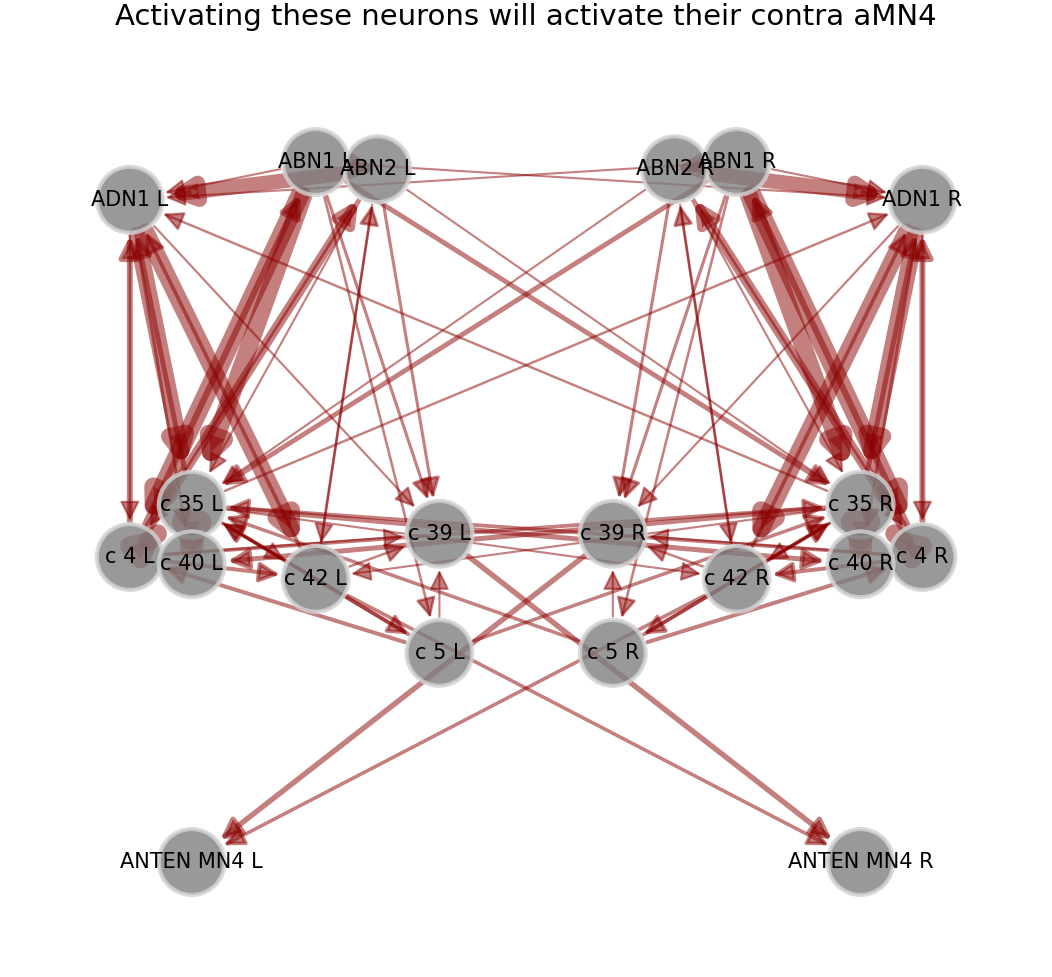

Minimum and maximum weights
0.0007754479593131691 4.070793505758047


In [17]:
# neurons affecting MN4 results
contra_active = [
    'ABN1_L',
    'ABN2_L',
    'ADN1_L',
    # ignore the commented ones because they are inactive
    # 'DN52_L',
    'c_4_L',
    'c_5_L',
    'c_35_L',
    # 'c_62_L',
    'c_39_L',
    'c_40_L',
    'c_42_L',
    'ANTEN_MN4_R',
    'ABN1_R',
    'ABN2_R',
    'ADN1_R',
    # 'DN52_R',
    'c_4_R',
    'c_5_R',
    'c_35_R',
    # 'c_62_R',
    'c_39_R',
    'c_40_R',
    'c_42_R',
    'ANTEN_MN4_L'
]
node_ids = [
    node_id
    for node_id, neuron_dict in node2name.items()
    if neuron_dict["name"] in contra_active
]

sub_network = connectivity[
    (connectivity.pre_root_id.isin(node_ids))
    & (connectivity.post_root_id.isin(node_ids))
].reset_index(drop=True)

# Drop weight lowert than MIN_SYN
sub_network = sub_network[abs(sub_network.weight) > MIN_SYN].reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.))
network_specs_motif1, subnetwork_motif1 = connectome_utils.plot_connectivity(
    sub_network,
    node2name,
    pos=node2pos,
    node_size=250,
    font_size=5,
    synapse_th=0,
    max_w=5,
    ax=ax,
    title=f"""Activating these neurons will activate their contra aMN4""",
    export_path=EXPORT_PATH / f"""Fig6_panelH.pdf""",
)
plt.show()

print("Minimum and maximum weights")
print(network_specs_motif1['weights'].min(),
      network_specs_motif1['weights'].max())


## Panel I: broadcast inhibition motif.

Note that we modified the node positions and edge colors in Gephi for better visualization. 

In [18]:
# Merge the excitatory cluster
# Define the pre_root_ids to merge
pre_root_ids_to_merge = [
    "ABN1",
    "ABN2",
    "ADN1",
    "c_4",
    "c_5",
    "c_35",
    "c_39",
    "c_42",
]

pre_root_left = [pre_root_id + "_L" for pre_root_id in pre_root_ids_to_merge]
pre_root_id_left = [
    node_id
    for node_id, neuron_dict in node2name.items()
    if neuron_dict["name"] in pre_root_left
]

pre_root_right = [pre_root_id + "_R" for pre_root_id in pre_root_ids_to_merge]
pre_root_id_right = [
    node_id
    for node_id, neuron_dict in node2name.items()
    if neuron_dict["name"] in pre_root_right
]
# replace pre_root_id with the new id
result_df = connectivity.copy()
# Define the condition to replace rows
condition1 = result_df["pre_root_id"].isin(pre_root_id_left)
condition2 = result_df["pre_root_id"].isin(pre_root_id_right)
result_df.loc[condition1, "pre_root_id"] = "EC_L"
result_df.loc[condition2, "pre_root_id"] = "EC_R"

agg_df = (
    result_df.groupby(["pre_root_id", "post_root_id"])
    .agg(
        {
            "weight": "sum",
            "syn_count": "sum",
            "syn_count_sign": "sum",
            "syn_inv": "sum",
            "nt_type": lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
        }
    )
    .reset_index()
)

add_post_df = agg_df.copy()

# Define the condition to replace rows
condition1 = add_post_df["post_root_id"].isin(pre_root_id_left)
condition2 = add_post_df["post_root_id"].isin(pre_root_id_right)
add_post_df.loc[condition1, "post_root_id"] = "EC_L"
add_post_df.loc[condition2, "post_root_id"] = "EC_R"

# Merge the rows
agg_df2 = (
    add_post_df.groupby(["pre_root_id", "post_root_id"])
    .agg(
        {
            "weight": "sum",
            "syn_count": "sum",
            "syn_count_sign": "sum",
            "syn_inv": "sum",
            "nt_type": lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
        }
    )
    .reset_index()
)

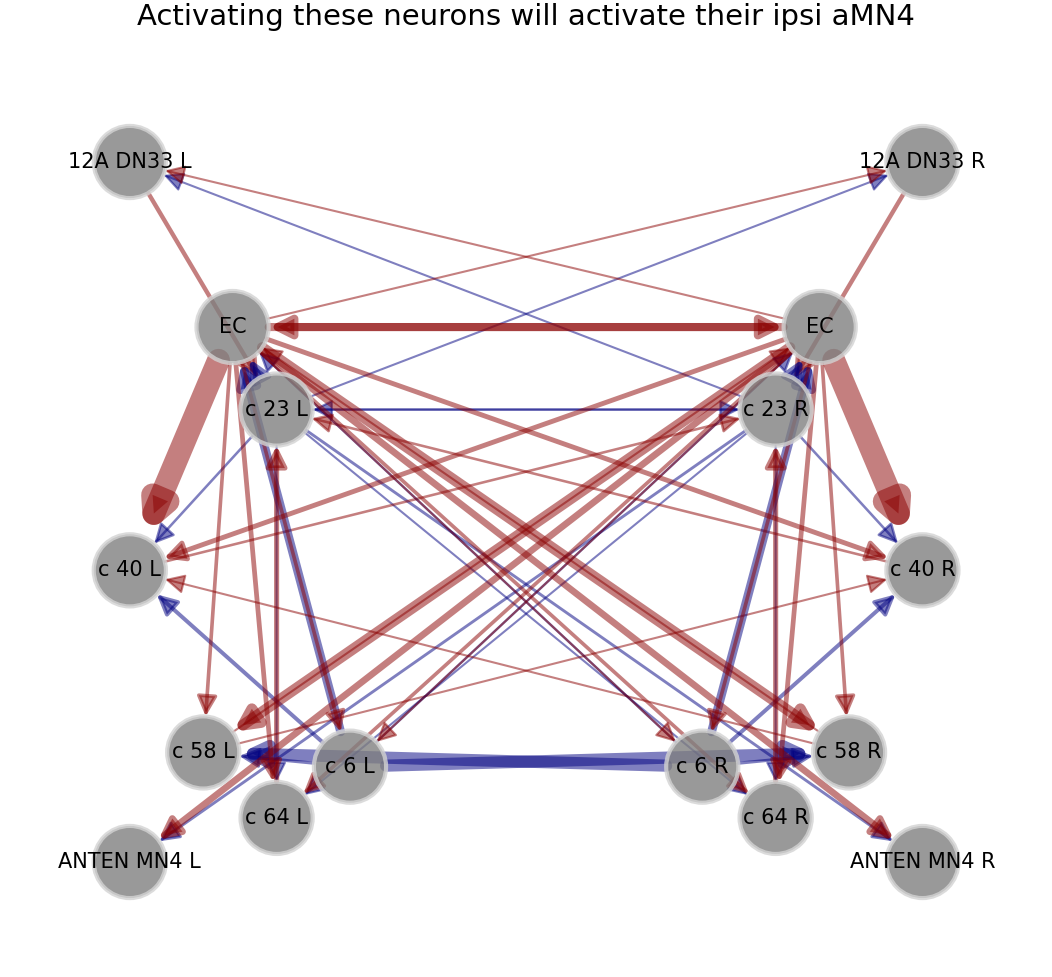

Minimum and maximum weights
4.9744317038857844e-05 4.238848568871617


In [19]:
ipsi_activate = [
    "c_6_L",
    "c_6_R",
    "c_23_L",
    "c_23_R",
    "c_40_L",
    "c_40_R",
    "c_49_L",
    "c_49_R",
    "c_58_L",
    "c_58_R",
    "c_64_L",
    "c_64_R",
    "12A_DN33_L",
    "12A_DN33_R",
    "ANTEN_MN4_L",
    "ANTEN_MN4_R",
    "DN52_R",
    "DN52_L",
    "c_62_R",
    "c_62_L",
]

# imp_neurons = set(ipsi_activate + contra_activate)
node_ids = [
    node_id
    for node_id, neuron_dict in node2name.items()
    if neuron_dict["name"] in ipsi_activate
] + ["EC_L", "EC_R"]

sub_network = agg_df2[
    (agg_df2.pre_root_id.isin(node_ids)) & (
        agg_df2.post_root_id.isin(node_ids))
].reset_index(drop=True)

# Drop weight lower than MIN_SYN
sub_network = sub_network[abs(sub_network.weight) > MIN_SYN].reset_index(drop=True)
# Remove self loop
sub_network = sub_network[sub_network.pre_root_id != sub_network.post_root_id].reset_index(drop=True)
pre_syn = sub_network.pre_root_id.unique()
post_syn = sub_network.post_root_id.unique()
# Intersection
intersect = set(pre_syn) & set(post_syn)
# add ANTEN MN4
intersect = intersect.union(
    [
        node_id
        for node_id, neuron_dict in node2name.items()
        if neuron_dict["name"] in ["ANTEN_MN4_L", "ANTEN_MN4_R"]
    ]
)

new_sub_network = sub_network[
    (sub_network.pre_root_id.isin(intersect)) & (
        sub_network.post_root_id.isin(intersect))
].reset_index(drop=True)

node2name["EC_L"] = {"name": "EC", "color": "grey", "nt": "ACH"}
node2name["EC_R"] = {"name": "EC", "color": "grey", "nt": "ACH"}
node2pos["EC_L"] = (-1, -4.5)
node2pos["EC_R"] = (+1, -4.5)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.))
network_specs_motif2, subnetwork_motif2 = connectome_utils.plot_connectivity(
    new_sub_network,
    node2name,
    pos=node2pos,
    node_size=300,
    font_size=5,
    synapse_th=0,
    max_w=5,
    ax=ax,
    title=f"""Activating these neurons will activate their ipsi aMN4""",
    export_path=EXPORT_PATH / f"""Fig6_panelI.png""",
)
plt.show()

print("Minimum and maximum weights")
print(network_specs_motif2['weights'].min(),
      network_specs_motif2['weights'].max())



## Panel G: neuronal groups of the clusters in the identified motifs.

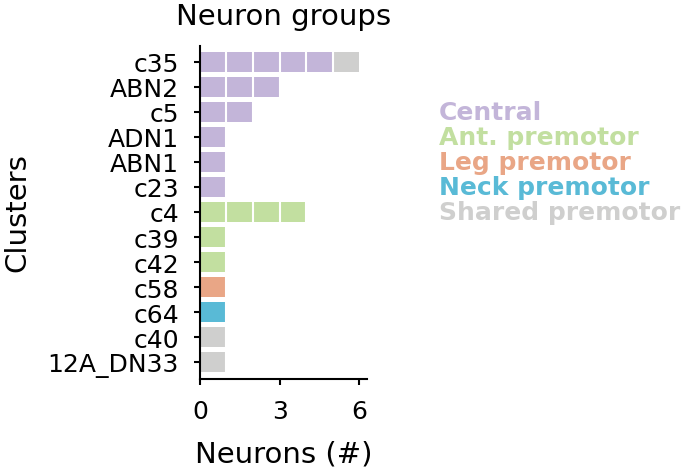

In [36]:

NODE_COLORS = {
    "JO-F": "#D45B83",
    'JO-C': "#934161",
    'JO-E': "#4F2334",
    "CENTRAL": "#C3B5D9",
    "ANTEN_PREM": "#C2DFA0",
    "NECK_PREM": "#59BAD6",
    "LEG_PREM": "#E9A686",
    "SHARED_PREM": "#CFCFCE",
    "ANTEN_MN": "#798963",
    "NECK_MN": "#356D7A",
    "OTHER": "black"
}

with plt.style.context("./config.mplstyle"):
    df_neurons = pd.read_pickle(DATA_PATH / "Fig6_panelG.pkl")
    order=[
        "cluster_35",
        "ABN2",
        "cluster_5",
        "ADN1",
        "ABN1",
        "cluster_23",
        "cluster_4",
        "cluster_39",
        "cluster_42",
        "cluster_58",
        "cluster_64",
        "cluster_40",
        "12A_DN33",
    ]

    fig, ax = plt.subplots(
        1, 1, figsize=(FIGSIZE["width"] * 0.6, FIGSIZE["length"] * 1.6)
    )

    cluster_module = pd.crosstab(df_neurons["cluster"], df_neurons["module"])
    sorted_cluster_module = cluster_module.reindex([x for x in order[::-1]], axis=0)

    ax = sorted_cluster_module.plot(
        kind="barh",
        stacked=True,
        width=0.8,
        ax=ax,
        color=[
            NODE_COLORS[col] if col in NODE_COLORS else NODE_COLORS["OTHER"]
            for col in sorted_cluster_module.columns
        ],

        legend=False,
    )
    ax.set_ylabel("Clusters", fontsize=7)
    ax.set_xlabel("Neurons (#)", fontsize=7)
    ax.set_title("Neuron groups", fontsize=7, y=0.99)

    ax.set_yticks(
        np.arange(0, len(order), 1),
        labels=[x.replace("cluster_", "c") for x in order[::-1]],
        fontsize=6,
        rotation=0,
    )
    # xticks
    ax.set_xticks(np.arange(0, 7, 3))

    # put hlines
    ax.axvline(1, color="white", linestyle="-", linewidth=0.5)
    ax.axvline(2, color="white", linestyle="-", linewidth=0.5)
    ax.axvline(3, color="white", linestyle="-", linewidth=0.5)
    ax.axvline(4, color="white", linestyle="-", linewidth=0.5)
    ax.axvline(5, color="white", linestyle="-", linewidth=0.5)

    # add labels as colored text
    ax.text(
        9,
        10,
        'Central',
        color=NODE_COLORS["CENTRAL"],
        fontsize=6,
        fontweight="bold",
        verticalalignment="center",
    )
    ax.text(
        9,
        9,
        'Ant. premotor',
        color=NODE_COLORS["ANTEN_PREM"],
        fontsize=6,
        fontweight="bold",
        verticalalignment="center",
    )
    ax.text(
        9,
        8,
        'Leg premotor',
        color=NODE_COLORS["LEG_PREM"],
        fontsize=6,
        fontweight="bold",
        verticalalignment="center",
    )
    ax.text(
        9,
        7,
        'Neck premotor',
        color=NODE_COLORS["NECK_PREM"],
        fontsize=6,
        fontweight="bold",
        verticalalignment="center",
    )
    ax.text(
        9,
        6,
        'Shared premotor',
        color=NODE_COLORS["SHARED_PREM"],
        fontsize=6,
        fontweight="bold",
        verticalalignment="center",
    )


    fig.savefig(
        EXPORT_PATH / "Fig6_panelG.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()